In [92]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [93]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [94]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [95]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [96]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [97]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [98]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [99]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [100]:
# Find the most recent date in the data set.
max_date = session.query(func.max(measurement.date)).all()
print(max_date)

[('2017-08-23',)]


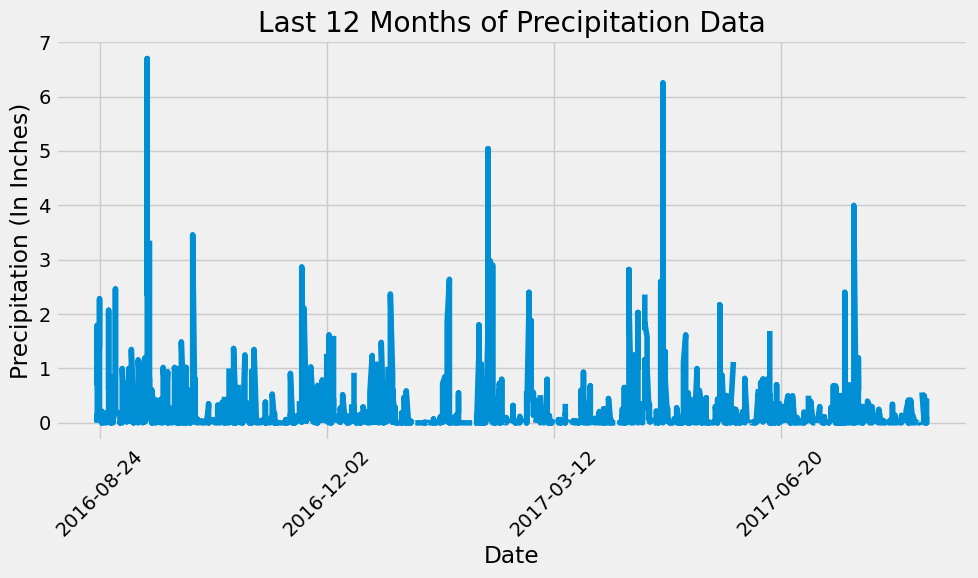

In [101]:
# Perform a query to retrieve the data and precipitation scores
query = """
        SELECT date, prcp
        FROM measurement
        WHERE date >= (SELECT DATE(MAX(date), '-1 year') FROM measurement)
        ORDER BY date
        """

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(query, engine)
df.columns = ['Date', 'Precipitation']
# Sort the dataframe by date
df.sort_values('Date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (In Inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(np.arange(1, 365, 100), rotation=45)
plt.tight_layout()
plt.show()

In [102]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [124]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).all()
print(total_stations)

[(9,)]


In [106]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
print(station_activity)

SELECT measurement.station AS measurement_station, count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC


In [113]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = station_activity.first()[0]
temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)) \
            .filter(measurement.station == most_active_station_id).all()
temp_stats

[(54.0, 85.0, 71.66378066378067)]

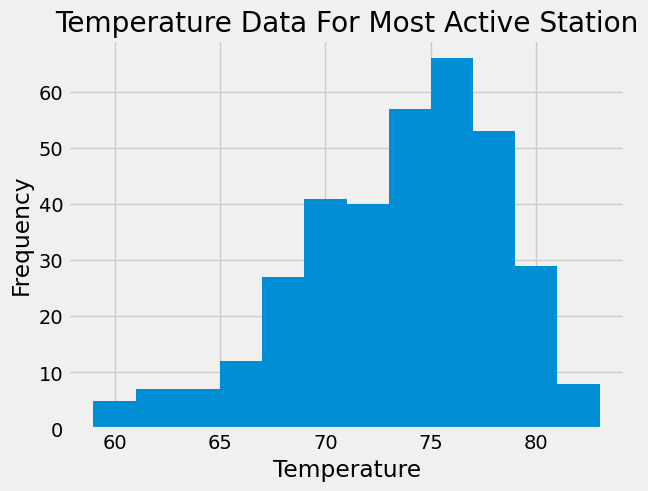

In [121]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prev_year_tobs = session.query(measurement.tobs) \
                .filter(measurement.station == most_active_station_id) \
                .filter(measurement.date >= '2016-08-23').all()
df = pd.DataFrame(prev_year_tobs, columns = ['tobs'])
plt.hist(df['tobs'], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Data For Most Active Station')
plt.show()

# Close Session

In [122]:
# Close Session
session.close()